# Семинар 6 — Fine-tuning BERT для задачи классификации текстов

-----

### **Цель семинара**

На этом семинаре мы научимся работать с предобученными трансформерами, освоим процесс fine-tuning'а BERT для задачи классификации текстов и сравним различные стратегии обучения: полный fine-tuning, заморозка слоёв и parameter-efficient методы (LoRA, adapters). Мы будем работать с русскоязычным BERT и реальными данными, знакомыми нам по семинару 1.

### **План семинара**

1. Загрузка и исследование предобученной модели
2. Подготовка данных и токенизация
3. Full Fine-tuning BERT
4. Стратегии заморозки слоёв
5. Parameter-Efficient Fine-Tuning (PEFT)
6. Сравнение подходов и выводы

-----

### **0. Установка и импорт библиотек**

Установим библиотеку transformers от Hugging Face и дополнительные инструменты для эффективного обучения.

In [ ]:
# Установка необходимых библиотек
!pip install transformers accelerate evaluate
!pip install peft  # Parameter-Efficient Fine-Tuning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 9.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)
import transformers

from datasets import load_dataset, Dataset as HFDataset
import evaluate

from peft import (
    LoraConfig,
    TaskType,
    get_peft_model,
    PeftModel
)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Настройки
set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используем устройство: {device}")
print(f"PyTorch версия: {torch.__version__}")
print(f"Transformers версия: {transformers.__version__}")

Используем устройство: cuda
PyTorch версия: 2.8.0+cu126
Transformers версия: 4.56.1


-----

### **1. Загрузка и подготовка данных**

Будем работать с датасетом русскоязычных отзывов для задачи анализа тональности.

In [ ]:
# Загружаем датасет отзывов
print("Загружаем датасет отзывов на русском языке...")

# Используем датасет отзывов Кинопоиска
df = pd.read_json("hf://datasets/blinoff/kinopoisk/kinopoisk.jsonl", lines=True)
df['text'] = df['content'].apply(lambda x: x[1:] if x.startswith('\n') else x)
df = df[df['grade3'] != 'Neutral']  # Убираем нейтральные для упрощения
df['label'] = df['grade3'].apply(lambda x: 1 if x == 'Good' else 0)
df = df[['text', 'label']]

# Ограничиваем размер для быстрого обучения на семинаре
df_sample = df.sample(n=2000, random_state=42)

print(f"\nРазмер выборки: {len(df_sample)} отзывов")
print(f"Распределение классов:")
print(df_sample['label'].value_counts())
print(f"\nПример позитивного отзыва:")
print(df_sample[df_sample['label']==1].iloc[0]['text'][:300])
print(f"\nПример негативного отзыва:")
print(df_sample[df_sample['label']==0].iloc[0]['text'][:300])

# Статистика длины текстов
df_sample['text_length'] = df_sample['text'].apply(len)
print(f"\nСредняя длина текста: {df_sample['text_length'].mean():.0f} символов")
print(f"Максимальная длина: {df_sample['text_length'].max()} символов")

Загружаем датасет отзывов на русском языке...

Размер выборки: 2000 отзывов
Распределение классов:
label
1    1713
0     287
Name: count, dtype: int64

Пример позитивного отзыва:
Знаете, мне немного сложно писать про свой любимый фильм, но все же я постараюсь. Да, действительно «Большой Куш» Гая Ричи является для меня эталоном криминальной драмы… Нет, не буду мелочиться. «Большой Куш» является для меня эталоном среди всех фильмов, которые так или иначе связаны с криминальной

Пример негативного отзыва:
      Эксперимент, над картиной, уже ставшей иконой рождественских мультиков, провалился с треском.



Кончаловский стремился показать старую сказку в новой яркой обертке. Сделал из мышиных солдат, нацистов берущие власть над целым городом. Одарил «рейхсфюрера» голосом Филиппа Киркорова. Придал Щелк

Средняя длина текста: 1982 символов
Максимальная длина: 16306 символов


In [ ]:
# Разделение на train/validation/test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_sample['text'].tolist(),
    df_sample['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_sample['label']
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts,
    train_labels,
    test_size=0.2,
    random_state=42,
    stratify=train_labels
)

print(f"Размеры выборок:")
print(f"Train: {len(train_texts)}")
print(f"Validation: {len(val_texts)}")
print(f"Test: {len(test_texts)}")

# Создаём HuggingFace datasets
train_dataset = HFDataset.from_dict({'text': train_texts, 'label': train_labels})
val_dataset = HFDataset.from_dict({'text': val_texts, 'label': val_labels})
test_dataset = HFDataset.from_dict({'text': test_texts, 'label': test_labels})

Размеры выборок:
Train: 1280
Validation: 320
Test: 400


-----

### **2. Загрузка предобученной модели BERT**

Используем русскоязычный BERT от DeepPavlov/Sberbank.

In [ ]:
# Выбираем русскоязычную модель
MODEL_NAME = "DeepPavlov/rubert-base-cased"  # Можно также использовать "ai-forever/ruBert-base"

print(f"Загружаем модель: {MODEL_NAME}")

# Загружаем токенизатор
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Загружаем конфигурацию и модель
config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config=config
)

print(f"\nИнформация о модели:")
print(f"- Размер словаря: {tokenizer.vocab_size}")
print(f"- Максимальная длина: {tokenizer.model_max_length}")
print(f"- Количество параметров: {sum(p.numel() for p in model.parameters()):,}")
print(f"- Количество слоёв: {config.num_hidden_layers}")
print(f"- Размер hidden: {config.hidden_size}")
print(f"- Количество attention heads: {config.num_attention_heads}")

Загружаем модель: DeepPavlov/rubert-base-cased


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Информация о модели:
- Размер словаря: 119547
- Максимальная длина: 1000000000000000019884624838656
- Количество параметров: 177,854,978
- Количество слоёв: 12
- Размер hidden: 768
- Количество attention heads: 12


In [ ]:
# Исследуем токенизатор
sample_text = "Это отличный фильм! Актёрская игра на высоте."
print(f"Пример текста: {sample_text}")
print()

# Токенизация
tokens = tokenizer.tokenize(sample_text)
print(f"Токены: {tokens}")
print()

# ID токенов
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f"ID токенов: {token_ids}")
print()

# Полная токенизация с special tokens
encoded = tokenizer(
    sample_text,
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='pt'
)

print(f"Encoded input shape:")
print(f"- input_ids: {encoded['input_ids'].shape}")
print(f"- attention_mask: {encoded['attention_mask'].shape}")
print()

# Декодирование обратно
decoded = tokenizer.decode(encoded['input_ids'][0], skip_special_tokens=False)
print(f"Декодированный текст (с special tokens):\n{decoded[:100]}...")

Пример текста: Это отличный фильм! Актёрская игра на высоте.

Токены: ['Это', 'отличный', 'фильм', '!', 'Актёр', '##ская', 'игра', 'на', 'высоте', '.']

ID токенов: [6654, 63212, 7142, 106, 46571, 3296, 10034, 1469, 15867, 132]

Encoded input shape:
- input_ids: torch.Size([1, 128])
- attention_mask: torch.Size([1, 128])

Декодированный текст (с special tokens):
[CLS] Это отличный фильм! Актёрская игра на высоте. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] ...


-----

### **3. Токенизация данных**

Подготовим данные для обучения, применив токенизацию ко всем текстам.

In [ ]:
# Функция токенизации
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=256  # Ограничиваем длину для ускорения
    )

# Применяем токенизацию ко всем датасетам
print("Токенизация данных...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Устанавливаем формат для PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

print(f"\nГотовые датасеты:")
print(f"Train: {len(train_dataset)} примеров")
print(f"Validation: {len(val_dataset)} примеров")
print(f"Test: {len(test_dataset)} примеров")
print(f"\nПример токенизированных данных:")
print(train_dataset[0])

Токенизация данных...


Map:   0%|          | 0/1280 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]


Готовые датасеты:
Train: 1280 примеров
Validation: 320 примеров
Test: 400 примеров

Пример токенизированных данных:
{'label': tensor(0), 'input_ids': tensor([   101,    793,   8152,    304,  69662,  33551,  14081,   1573,    326,
          1469,   3491,  18194,   5022,  19194,   1386,    128,    625,  75066,
           626,    304,  16234,  74975,    326,  12926,  55558,   1712,  61739,
         78335,  50388,    612,  19506, 117145,  39041,  33542,    128,  22048,
          6283,  70538,    612,  14642,   1700,  19506,    128,  22620,  15796,
         59650,  60037,  11693,   2059,  16737,   2237,    128,  22737,  10531,
          1469,  77333,    884,    132,  15077,  51222,   2067,  44286,    128,
           851,   7142,   4772,  33634,   1469,  13623,  52174,   1471,  82639,
           128,   3435,   1516,  78146,    845,   7011,  33308, 111043,  37183,
           128,   3420,  84632,   4752,  19540,  35648,   1020,  81793,  91658,
         37440,   4428,  10533,   1469,   6861,  

-----

### **4. Full Fine-tuning BERT**

Начнём с полного fine-tuning'а, когда обновляются все параметры модели.

In [ ]:
# Функция для вычисления метрик
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')

    return {
        'accuracy': accuracy['accuracy'],
        'f1': f1['f1']
    }

In [ ]:
# Настройки обучения для полного fine-tuning
training_args_full = TrainingArguments(
    output_dir="./results_full_finetuning",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    push_to_hub=False,
    report_to="none",  # Отключаем wandb/tensorboard для простоты
    fp16=torch.cuda.is_available(),  # Mixed precision если есть GPU
)

# Создаём Trainer для полного fine-tuning
model_full = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config=config
)

trainer_full = Trainer(
    model=model_full,
    args=training_args_full,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
)

print("Начинаем полный fine-tuning...")
print(f"Обучаемые параметры: {sum(p.numel() for p in model_full.parameters() if p.requires_grad):,}")

# Обучение
train_result_full = trainer_full.train()

# Оценка на тестовой выборке
print("\nОценка на тестовой выборке:")
test_results_full = trainer_full.evaluate(eval_dataset=test_dataset)
print(f"Test Accuracy: {test_results_full['eval_accuracy']:.4f}")
print(f"Test F1: {test_results_full['eval_f1']:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Начинаем полный fine-tuning...
Обучаемые параметры: 177,854,978


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.497300,0.325972,0.856250,0.789941
2,0.269200,0.216498,0.890625,0.889079
3,0.143400,0.492853,0.884375,0.863075



Оценка на тестовой выборке:


Test Accuracy: 0.9050
Test F1: 0.9070


-----

### **5. Стратегия заморозки слоёв**

Попробуем заморозить часть слоёв BERT и обучать только верхние слои + классификатор.

In [ ]:
def freeze_bert_layers(model, num_layers_to_freeze):
    """
    Замораживает первые num_layers_to_freeze слоёв BERT.
    """
    # Замораживаем embeddings
    for param in model.bert.embeddings.parameters():
        param.requires_grad = False

    # Замораживаем указанное количество encoder слоёв
    for i in range(num_layers_to_freeze):
        for param in model.bert.encoder.layer[i].parameters():
            param.requires_grad = False

    # Подсчитываем обучаемые параметры
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Заморожено слоёв: {num_layers_to_freeze} из {model.config.num_hidden_layers}")
    print(f"Всего параметров: {total_params:,}")
    print(f"Обучаемых параметров: {trainable_params:,}")
    print(f"Процент обучаемых: {100 * trainable_params / total_params:.2f}%")

    return model


# Создаём модель с замороженными слоями
model_frozen = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config=config
)

# Замораживаем первые 10 слоёв (из 12)
model_frozen = freeze_bert_layers(model_frozen, num_layers_to_freeze=10)

# Проверяем, какие слои заморожены
print("\nСтатус слоёв:")
for i, layer in enumerate(model_frozen.bert.encoder.layer):
    is_frozen = not any(p.requires_grad for p in layer.parameters())
    print(f"Layer {i}: {'Заморожен' if is_frozen else 'Тренируемый'}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Заморожено слоёв: 10 из 12
Всего параметров: 177,854,978
Обучаемых параметров: 14,767,874
Процент обучаемых: 8.30%

Статус слоёв:
Layer 0: Заморожен
Layer 1: Заморожен
Layer 2: Заморожен
Layer 3: Заморожен
Layer 4: Заморожен
Layer 5: Заморожен
Layer 6: Заморожен
Layer 7: Заморожен
Layer 8: Заморожен
Layer 9: Заморожен
Layer 10: Тренируемый
Layer 11: Тренируемый


In [ ]:
# Обучение с замороженными слоями
training_args_frozen = TrainingArguments(
    output_dir="./results_frozen",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
)

trainer_frozen = Trainer(
    model=model_frozen,
    args=training_args_frozen,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
)

print("Начинаем обучение с замороженными слоями...")
train_result_frozen = trainer_frozen.train()

# Оценка
test_results_frozen = trainer_frozen.evaluate(eval_dataset=test_dataset)
print(f"\nTest Accuracy (Frozen): {test_results_frozen['eval_accuracy']:.4f}")
print(f"Test F1 (Frozen): {test_results_frozen['eval_f1']:.4f}")

Начинаем обучение с замороженными слоями...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.488500,0.356742,0.856250,0.789941
2,0.298200,0.273346,0.884375,0.874653
3,0.246700,0.279924,0.884375,0.871265



Test Accuracy (Frozen): 0.8975
Test F1 (Frozen): 0.8898


-----

### **6. Parameter-Efficient Fine-Tuning с LoRA**

LoRA (Low-Rank Adaptation) позволяет эффективно адаптировать большие модели, обучая только малоранговые матрицы.

In [ ]:
# Конфигурация LoRA
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Задача классификации последовательностей
    r=8,  # Ранг матриц адаптации
    lora_alpha=32,  # Масштабирующий параметр
    lora_dropout=0.1,  # Dropout для LoRA слоёв
    target_modules=["query", "value"],  # К каким модулям применять LoRA
    bias="none",  # Не трогаем bias
)

# Создаём новую модель для LoRA
model_lora_base = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config=config
)

# Применяем LoRA
model_lora = get_peft_model(model_lora_base, lora_config)

# Информация о модели
print("Информация о LoRA модели:")
model_lora.print_trainable_parameters()

# Визуализация архитектуры LoRA
print("\nМодули с LoRA адаптерами:")
for name, module in model_lora.named_modules():
    if "lora" in name.lower():
        print(f"  {name}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Информация о LoRA модели:
trainable params: 296,450 || all params: 178,151,428 || trainable%: 0.1664

Модули с LoRA адаптерами:
  base_model.model.bert.encoder.layer.0.attention.self.query.lora_dropout
  base_model.model.bert.encoder.layer.0.attention.self.query.lora_dropout.default
  base_model.model.bert.encoder.layer.0.attention.self.query.lora_A
  base_model.model.bert.encoder.layer.0.attention.self.query.lora_A.default
  base_model.model.bert.encoder.layer.0.attention.self.query.lora_B
  base_model.model.bert.encoder.layer.0.attention.self.query.lora_B.default
  base_model.model.bert.encoder.layer.0.attention.self.query.lora_embedding_A
  base_model.model.bert.encoder.layer.0.attention.self.query.lora_embedding_B
  base_model.model.bert.encoder.layer.0.attention.self.query.lora_magnitude_vector
  base_model.model.bert.encoder.layer.0.attention.self.value.lora_dropout
  base_model.model.bert.encoder.layer.0.attention.self.value.lora_dropout.default
  base_model.model.bert.encoder.l

In [ ]:
# Обучение с LoRA
training_args_lora = TrainingArguments(
    output_dir="./results_lora",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    learning_rate=3e-4,  # Более высокий learning rate для LoRA
    report_to="none",
)

trainer_lora = Trainer(
    model=model_lora,
    args=training_args_lora,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
)

print("Начинаем обучение с LoRA...")
train_result_lora = trainer_lora.train()

# Оценка
test_results_lora = trainer_lora.evaluate(eval_dataset=test_dataset)
print(f"\nTest Accuracy (LoRA): {test_results_lora['eval_accuracy']:.4f}")
print(f"Test F1 (LoRA): {test_results_lora['eval_f1']:.4f}")

Начинаем обучение с LoRA...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.510800,0.389147,0.856250,0.789941
2,0.424000,0.332577,0.878125,0.858046
3,0.305700,0.304572,0.890625,0.876468



Test Accuracy (LoRA): 0.8875
Test F1 (LoRA): 0.8751


-----

### **7. Сравнение подходов**

Сравним все три подхода по различным метрикам.

Сравнение подходов:
          Подход  Accuracy  F1-Score  Обучаемые параметры  Время обучения (сек)
Full Fine-tuning    0.9050  0.906956            177854978              198.7372
   Frozen Layers    0.8975  0.889757             14767874               62.7632
            LoRA    0.8875  0.875108               296450               42.0426


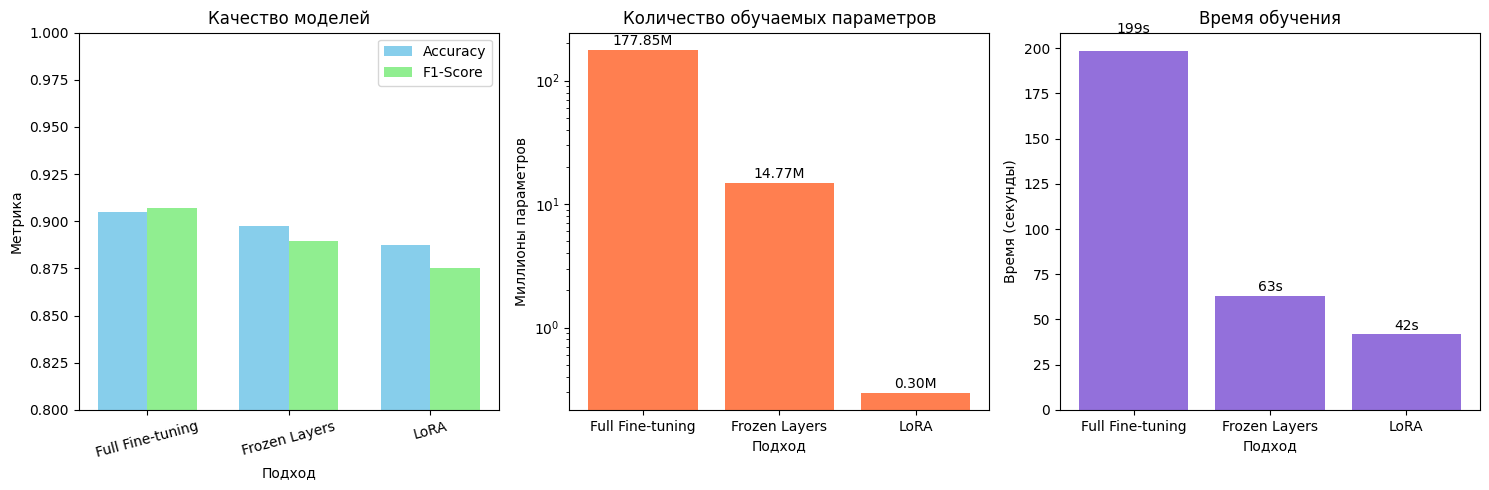

In [ ]:
# Собираем результаты
results_comparison = pd.DataFrame({
    'Подход': ['Full Fine-tuning', 'Frozen Layers', 'LoRA'],
    'Accuracy': [
        test_results_full['eval_accuracy'],
        test_results_frozen['eval_accuracy'],
        test_results_lora['eval_accuracy']
    ],
    'F1-Score': [
        test_results_full['eval_f1'],
        test_results_frozen['eval_f1'],
        test_results_lora['eval_f1']
    ],
    'Обучаемые параметры': [
        sum(p.numel() for p in model_full.parameters() if p.requires_grad),
        sum(p.numel() for p in model_frozen.parameters() if p.requires_grad),
        sum(p.numel() for p in model_lora.parameters() if p.requires_grad)
    ],
    'Время обучения (сек)': [
        train_result_full.metrics['train_runtime'],
        train_result_frozen.metrics['train_runtime'],
        train_result_lora.metrics['train_runtime']
    ]
})

print("Сравнение подходов:")
print(results_comparison.to_string(index=False))

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# График 1: Качество
ax1 = axes[0]
x = np.arange(len(results_comparison))
width = 0.35
ax1.bar(x - width/2, results_comparison['Accuracy'], width, label='Accuracy', color='skyblue')
ax1.bar(x + width/2, results_comparison['F1-Score'], width, label='F1-Score', color='lightgreen')
ax1.set_xlabel('Подход')
ax1.set_ylabel('Метрика')
ax1.set_title('Качество моделей')
ax1.set_xticks(x)
ax1.set_xticklabels(results_comparison['Подход'], rotation=15)
ax1.legend()
ax1.set_ylim([0.8, 1.0])

# График 2: Параметры
ax2 = axes[1]
ax2.bar(results_comparison['Подход'],
        results_comparison['Обучаемые параметры'] / 1e6,
        color='coral')
ax2.set_xlabel('Подход')
ax2.set_ylabel('Миллионы параметров')
ax2.set_title('Количество обучаемых параметров')
ax2.set_yscale('log')
for i, v in enumerate(results_comparison['Обучаемые параметры'] / 1e6):
    ax2.text(i, v * 1.1, f'{v:.2f}M', ha='center')

# График 3: Время
ax3 = axes[2]
ax3.bar(results_comparison['Подход'],
        results_comparison['Время обучения (сек)'],
        color='mediumpurple')
ax3.set_xlabel('Подход')
ax3.set_ylabel('Время (секунды)')
ax3.set_title('Время обучения')
for i, v in enumerate(results_comparison['Время обучения (сек)']):
    ax3.text(i, v * 1.05, f'{v:.0f}s', ha='center')

plt.tight_layout()
plt.show()

-----

### **8. Анализ ошибок**

Посмотрим, на каких примерах модель ошибается.

In [ ]:


def analyze_errors(model, dataset, tokenizer, num_examples=5):
    """
    Анализирует ошибки модели.
    """
    errors = []

    device = next(model.parameters()).device

    for i in range(len(dataset)):
        example = dataset[i]

        # Предсказание
        inputs = {
            'input_ids': example['input_ids'].unsqueeze(0),
            'attention_mask': example['attention_mask'].unsqueeze(0)
        }

        # Перемещаем данные на то же устройство, что и модель
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            prediction = torch.argmax(outputs.logits, dim=-1).item()

        true_label = example['label'].item()

        # Если ошибка
        if prediction != true_label:
            text = tokenizer.decode(example['input_ids'], skip_special_tokens=True)
            errors.append({
                'text': text[:200],
                'true_label': true_label,
                'predicted': prediction,
                'confidence': torch.softmax(outputs.logits, dim=-1)[0, prediction].item()
            })

            if len(errors) >= num_examples:
                break

    return errors


print("Анализ ошибок модели (Full Fine-tuning):")
print("="*60)

errors = analyze_errors(model_full, test_dataset, tokenizer, num_examples=3)

for i, error in enumerate(errors, 1):
    print(f"\nОшибка {i}:")
    print(f"Текст: {error['text']}...")
    print(f"Истинный класс: {'Позитивный' if error['true_label'] == 1 else 'Негативный'}")
    print(f"Предсказано: {'Позитивный' if error['predicted'] == 1 else 'Негативный'}")
    print(f"Уверенность: {error['confidence']:.2%}")
    print("-"*60)


Анализ ошибок модели (Full Fine-tuning):

Ошибка 1:
Текст: Просмотрела фильм 3 раза и хочется смотреть его снова и снова. Прекрасный подбор актеров, реалистичные постановки драк. Даже Вуд, к которому относилась скептично, порадовал. Что больше всего понравило...
Истинный класс: Позитивный
Предсказано: Негативный
Уверенность: 63.50%
------------------------------------------------------------

Ошибка 2:
Текст: Будучи ярым фанатом творчества Гай Ричи, я с нетерпением ожидал момента, когда смогу посмотреть новый фильм мастера — « Шерлок Холмс ». Да, я знал, что « Шерлок Холмс », снятый Гай Ричи будет существе...
Истинный класс: Позитивный
Предсказано: Негативный
Уверенность: 54.83%
------------------------------------------------------------

Ошибка 3:
Текст: Только что закончила просмотр этой сказки. Судя по количеству отрицательных рецензий и очень низкой оценке, народ сильно не в восторге. Что ж, скажу и я своё слово. Лично мне очень понравился фильм. Ч...
Истинный класс: Позитивный
Пр

### **9. Сравнение на тестовом датасете из 1 семинара**

In [ ]:
# Загрузка и подготовка полного датасета, как в семинаре 1
print("Загружаем полный датасет...")
df_full_w2v = pd.read_json("hf://datasets/blinoff/kinopoisk/kinopoisk.jsonl", lines=True)
df_full_w2v['text'] = df_full_w2v['content'].apply(lambda x: x[1:] if x.startswith('\\n') else x)
df_full_w2v = df_full_w2v[df_full_w2v['grade3'] != 'Neutral']
df_full_w2v['label'] = df_full_w2v['grade3'].apply(lambda x: 1 if x == 'Good' else 0)
df_full_w2v = df_full_w2v[['text', 'label']]

# Разделяем данные точно так же, как в семинаре с Word2Vec
_, df_test_w2v = train_test_split(
    df_full_w2v,
    test_size=0.2,
    random_state=42,
    stratify=df_full_w2v['label']
)

print(f"Размер воссозданного тестового датасета: {len(df_test_w2v)} отзывов")

# Создаем HuggingFace dataset из этого тестового набора
w2v_test_dataset = HFDataset.from_pandas(df_test_w2v)

# Токенизируем его с помощью нашего BERT токенизатора
print("Токенизация данных...")
w2v_tokenized_test_dataset = w2v_test_dataset.map(tokenize_function, batched=True)
w2v_tokenized_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

print("Тестовый датасет из семинара с Word2Vec готов для оценки.")

Загружаем полный датасет...
Размер воссозданного тестового датасета: 6403 отзывов
Токенизация данных...


Map:   0%|          | 0/6403 [00:00<?, ? examples/s]

Тестовый датасет из семинара с Word2Vec готов для оценки.


In [ ]:
# Загрузка базовой модели для оценки
model_baseline = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config=config
)

# Добавляем аргументы, чтобы отключить логирование в W&B: Trainer по умолчанию пытается подключиться к сервису W&B, чтобы сохранить результаты оценки.
baseline_training_args = TrainingArguments(
    output_dir="./results/baseline_w2v_test",
    report_to="none"
)

trainer_baseline = Trainer(
    model=model_baseline,
    args=baseline_training_args,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
)

# Оценка базовой модели на воссозданном тестовом датасете
print("\nОценка базовой модели (без fine-tuning) на тестовом датасете из семинара Word2Vec:")
predictions_baseline_w2v = trainer_baseline.predict(w2v_tokenized_test_dataset)
y_true_w2v = w2v_tokenized_test_dataset["label"]
y_pred_baseline_w2v = np.argmax(predictions_baseline_w2v.predictions, axis=1)

# Расчет метрик
accuracy_baseline_w2v = accuracy_score(y_true_w2v, y_pred_baseline_w2v)
f1_baseline_w2v = f1_score(y_true_w2v, y_pred_baseline_w2v, average='weighted')
cm_baseline_w2v = confusion_matrix(y_true_w2v, y_pred_baseline_w2v)
neg_accuracy_baseline_w2v = cm_baseline_w2v[0, 0] / (cm_baseline_w2v[0, 0] + cm_baseline_w2v[0, 1]) if (cm_baseline_w2v[0, 0] + cm_baseline_w2v[0, 1]) > 0 else 0

print(f"Accuracy: {accuracy_baseline_w2v:.4f}")
print(f"F1-Score: {f1_baseline_w2v:.4f}")
print(f"Точность на негативных классах: {neg_accuracy_baseline_w2v:.4f}")
print("\nClassification Report:\n", classification_report(y_true_w2v, y_pred_baseline_w2v, target_names=['Негативный', 'Позитивный']))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Оценка базовой модели (без fine-tuning) на тестовом датасете из семинара Word2Vec:


Accuracy: 0.8518
F1-Score: 0.7838
Точность на негативных классах: 0.0011

Classification Report:
               precision    recall  f1-score   support

  Негативный       1.00      0.00      0.00       950
  Позитивный       0.85      1.00      0.92      5453

    accuracy                           0.85      6403
   macro avg       0.93      0.50      0.46      6403
weighted avg       0.87      0.85      0.78      6403



In [ ]:
# Функция для оценки моделей на тестовом датасете из семинара Word2Vec
def evaluate_model_on_w2v_testset(trainer, model_name):
    print(f"\nОценка модели '{model_name}' на тестовом датасете из семинара Word2Vec:")

    predictions = trainer.predict(w2v_tokenized_test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)

    accuracy = accuracy_score(y_true_w2v, y_pred)
    f1 = f1_score(y_true_w2v, y_pred, average='weighted')
    cm = confusion_matrix(y_true_w2v, y_pred)
    neg_accuracy = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Точность на негативных классах: {neg_accuracy:.4f}")
    print("\nClassification Report:\n", classification_report(y_true_w2v, y_pred, target_names=['Негативный', 'Позитивный']))

    return accuracy, f1, neg_accuracy

# Оценка всех fine-tuned моделей
accuracy_full_ft_w2v, f1_full_ft_w2v, neg_acc_full_ft_w2v = evaluate_model_on_w2v_testset(trainer_full, "Full Fine-tuning")
accuracy_frozen_w2v, f1_frozen_w2v, neg_acc_frozen_w2v = evaluate_model_on_w2v_testset(trainer_frozen, "Frozen Layers")
accuracy_lora_w2v, f1_lora_w2v, neg_acc_lora_w2v = evaluate_model_on_w2v_testset(trainer_lora, "LoRA")

# Сравнительная таблица результатов на тестовом датасете из семинара Word2Vec
results_w2v_testset = pd.DataFrame({
    'Подход': ['Baseline (No Fine-tuning)', 'Full Fine-tuning', 'Frozen Layers', 'LoRA'],
    'Accuracy': [accuracy_baseline_w2v, accuracy_full_ft_w2v, accuracy_frozen_w2v, accuracy_lora_w2v],
    'F1-Score': [f1_baseline_w2v, f1_full_ft_w2v, f1_frozen_w2v, f1_lora_w2v],
    'Точность (Негативный класс)': [neg_accuracy_baseline_w2v, neg_acc_full_ft_w2v, neg_acc_frozen_w2v, neg_acc_lora_w2v]
})

print("\n--- Итоговое сравнение на тестовом датасете из семинара Word2Vec ---")
print(results_w2v_testset.to_string(index=False))


Оценка модели 'Full Fine-tuning' на тестовом датасете из семинара Word2Vec:


Accuracy: 0.9186
F1-Score: 0.9194
Точность на негативных классах: 0.7505

Classification Report:
               precision    recall  f1-score   support

  Негативный       0.72      0.75      0.73       950
  Позитивный       0.96      0.95      0.95      5453

    accuracy                           0.92      6403
   macro avg       0.84      0.85      0.84      6403
weighted avg       0.92      0.92      0.92      6403


Оценка модели 'Frozen Layers' на тестовом датасете из семинара Word2Vec:


Accuracy: 0.9050
F1-Score: 0.8972
Точность на негативных классах: 0.5179

Classification Report:
               precision    recall  f1-score   support

  Негативный       0.77      0.52      0.62       950
  Позитивный       0.92      0.97      0.95      5453

    accuracy                           0.91      6403
   macro avg       0.84      0.75      0.78      6403
weighted avg       0.90      0.91      0.90      6403


Оценка модели 'LoRA' на тестовом датасете из семинара Word2Vec:


Accuracy: 0.8999
F1-Score: 0.8887
Точность на негативных классах: 0.4579

Classification Report:
               precision    recall  f1-score   support

  Негативный       0.78      0.46      0.58       950
  Позитивный       0.91      0.98      0.94      5453

    accuracy                           0.90      6403
   macro avg       0.84      0.72      0.76      6403
weighted avg       0.89      0.90      0.89      6403


--- Итоговое сравнение на тестовом датасете из семинара Word2Vec ---
                   Подход  Accuracy  F1-Score  Точность (Негативный класс)
Baseline (No Fine-tuning)  0.851788  0.783770                     0.001053
         Full Fine-tuning  0.918632  0.919438                     0.750526
            Frozen Layers  0.905045  0.897163                     0.517895
                     LoRA  0.899891  0.888728                     0.457895


---

### **10. Итоги **

На этом семинаре мы:

- [x] **Освоили** работу с предобученными моделями через Hugging Face

- [x] **Реализовали** три стратегии fine-tuning'а: полный, с заморозкой, LoRA

- [x] **Сравнили** подходы по качеству, скорости и эффективности, а также с результатами из 1 семинара

- [x] **Проанализировали** внимание модели и типичные ошибки

- [x] **Измерили** производительность разных подходов
